In [3]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import keras
import tensorflow as tf
from keras.utils.vis_utils import plot_model

In [4]:
# Load Huggingface transformers

#libraries
import pandas as pd
import requests
import io
from  urllib.request import urlopen
import torch 
import numpy as np
import sklearn
from sklearn.metrics.pairwise import cosine_similarity
from statistics import mean , variance
import math
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
import seaborn as sns


# Importing stock ml libraries
import warnings
warnings.simplefilter('ignore')
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn import metrics
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
import logging
logging.basicConfig(level=logging.ERROR)
from functools import reduce


In [5]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
full_data = pd.read_csv('./data/ATIS.csv')
full_data.head()

,utterance,intent_label
0,i'd like to see the fare code again qx,atis_abbreviation
1,what flights leave from atlanta to boston on j...,atis_flight
2,which airlines have flights between charlotte ...,atis_airline
3,what's the lowest round trip fare from atlanta...,atis_airfare
4,what is the latest return flight from atlanta ...,atis_flight


In [7]:
c_flight = full_data[full_data.intent_label == 'atis_flight'].sample(n=200, replace = False , random_state=42)
c_airfare = full_data[full_data.intent_label == 'atis_airfare'].sample(n=200, replace = False,  random_state=42)
c_ground_service = full_data[full_data.intent_label == 'atis_ground_service'].sample(n=291, replace = False, random_state=42)
c_airline = full_data[full_data.intent_label == 'atis_airline'].sample(n=195, replace = False, random_state=42)
c_abbreviation = full_data[full_data.intent_label == 'atis_abbreviation'].sample(n=180, replace = False, random_state=42)
data_frames = [c_flight, c_airfare, c_ground_service, c_airline, c_abbreviation]
full_data_new = reduce(lambda  left,right: pd.concat([left,right], ignore_index=True), data_frames)
full_data_new = full_data_new.sample(n=len(full_data_new), random_state=42).reset_index(drop=True)

In [8]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 600
# Max number of words in each utterance.
MAX_SEQUENCE_LENGTH = 100
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(full_data_new['utterance'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 508 unique tokens.


In [9]:
X  = tokenizer.texts_to_sequences(full_data_new['utterance'].values)
X  = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Y = pd.get_dummies(full_data_new['intent_label'].values)
Y = Y.to_numpy()

print('Shape of label tensor:', Y.shape)

Shape of data tensor: (1066, 100)
Shape of label tensor: (1066, 5)


In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [11]:
from sklearn.model_selection import KFold
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.layers import Bidirectional, GRU, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

num_folds = 5

# Define per-fold score containers <-- these are new
acc_per_fold = []
loss_per_fold = []

# Merge inputs and targets
inputs = X
targets = Y

# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)

epochs = [10, 20, 30, 40]
batch_sizes = [10, 20, 30, 40]
stats = {}

In [12]:
# K-fold Cross Validation model evaluation


print('------------------------------------------------------------------------')
fold_no = 1
for train, test in kfold.split(inputs, targets):

    # Define the model architecture
    model = keras.Sequential()
    model.add(tf.keras.layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=inputs[train].shape[1]))
    model.add(tf.keras.layers.SpatialDropout1D(0.2))
    model.add(tf.keras.layers.LSTM(100, dropout=0.2, recurrent_dropout=0.2))
    model.add(tf.keras.layers.Dense(5, activation='softmax'))
    opt = keras.optimizers.Adam(learning_rate=1e-3)
    model.compile(loss='categorical_crossentropy', optimizer= opt, metrics=['accuracy'])

    epoch = 5
    batch_size = 20

      # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

      # Fit data to model
    history = model.fit(inputs[train], targets[train],  epochs=epoch, batch_size=batch_size)
  
      ##add plotting function later --LATER
  
      # Generate generalization metrics
    scores = model.evaluate(inputs[test], targets[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

      # Increase fold number
    fold_no = fold_no + 1

    # == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

avg_acc = np.mean(acc_per_fold)
avg_loss = np.mean(loss_per_fold)

stats[(epoch, batch_size)] = (avg_acc, avg_loss)


------------------------------------------------------------------------
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/5
43/43 [==============================] - 10s 176ms/step - loss: 1.5517 - accuracy: 0.2948
Epoch 2/5
43/43 [==============================] - 8s 178ms/step - loss: 1.0045 - accuracy: 0.6155
Epoch 3/5
43/43 [==============================] - 8s 181ms/step - loss: 0.5038 - accuracy: 0.7904
Epoch 4/5
43/43 [==============================] - 8s 180ms/step - loss: 0.2684 - accuracy: 0.9186
Epoch 5/5
43/43 [==============================] - 8s 177ms/step - loss: 0.1362 - accuracy: 0.9699
Score for fold 1: loss of 0.17485184967517853; accuracy of 95.32710313796997%
------------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/5
43/43 [==============================] - 10s 180ms/step - loss: 1.5482 - accuracy: 0.2874
Epoch 2/5
43/43 [==============================] - 8s 180ms

In [13]:
ypred = [np.argmax(x) for x in model.predict(X)]
ypred_new = []
for x in ypred:
  if x == 0:
    ypred_new.append('atis_abbreviation')
  elif x == 1:
    ypred_new.append('atis_airfare')
  elif x == 2:
    ypred_new.append('atis_airline')
  elif x == 3:
    ypred_new.append('atis_flight')
  elif x == 4:
    ypred_new.append('atis_ground_service')

yprob = model.predict_proba(X)


In [15]:
prob_df = pd.DataFrame(zip(list(full_data_new['utterance']), list(full_data_new['intent_label']), ypred_new, yprob), columns = ['utterance', 'intent',
                                                                                                                            'pred_intent', 'prob'])

correct = prob_df[prob_df.intent == prob_df.pred_intent]

correct[['atis_abbreviation','atis_airfare', 'atis_airline', 'atis_flight', 'atis_ground_service']] = pd.DataFrame(correct.prob.tolist(), index= correct.index)
correct = correct.drop(['prob'], axis = 1)

correct.head()

,utterance,intent,pred_intent,atis_abbreviation,atis_airfare,atis_airline,atis_flight,atis_ground_service
1,which airlines fly from toronto to san diego a...,atis_airline,atis_airline,0.001165,0.000328,0.990873,0.007407,0.000227
2,dallas ground transportation,atis_ground_service,atis_ground_service,0.007392,0.001145,0.002483,0.001878,0.987102
3,explain restriction ap 57,atis_abbreviation,atis_abbreviation,0.985235,0.001110,0.007983,0.000475,0.005197
4,airline that stands for dl,atis_airline,atis_airline,0.005713,0.000950,0.982742,0.010350,0.000244
5,list the airlines that have nonstop afternoon ...,atis_airline,atis_airline,0.000277,0.000275,0.987468,0.011943,0.000037


In [63]:
correct.to_csv('./results/ATIS_preds.csv', index = False)

In [11]:
import pandas as pd
correct = pd.read_csv('./results/ATIS_preds.csv')

In [12]:
##membership from softmax

def get_mem_dist(intent):
  print("True positives for ", intent)
  plt.figure()

  plot_tp = sns.distplot(correct[correct.pred_intent == intent][intent])
  # mid_point = 0.5*(min(correct[correct.pred_intent == intent][intent]) + max(correct[correct.pred_intent == intent][intent]))

  print('Range is:', round(min(correct[correct.pred_intent == intent][intent]),3), 
        "-", round(max(correct[correct.pred_intent == intent][intent]),3)
        # , round(mid_point, 3)
        )
  plot_tp
  
  print("True negatives for ", intent)

  plot_tn = sns.distplot(correct[correct.pred_intent != intent][intent])
  # mid_point = 0.5*(min(correct[correct.pred_intent != intent][intent])+max(correct[correct.pred_intent != intent][intent]))
  print('Range is:', round(min(correct[correct.pred_intent != intent][intent]),3), 
        "-", round(max(correct[correct.pred_intent != intent][intent]),3)
        # ,round(mid_point, 3)
        )
  plot_tn


True positives for  atis_abbreviation
Range is: 0.652 - 0.997
True negatives for  atis_abbreviation
Range is: 0.0 - 0.394
True positives for  atis_airfare
Range is: 0.516 - 0.994
True negatives for  atis_airfare
Range is: 0.0 - 0.336
True positives for  atis_ground_service
Range is: 0.621 - 1.0
True negatives for  atis_ground_service
Range is: 0.0 - 0.327
True positives for  atis_flight
Range is: 0.332 - 0.989
True negatives for  atis_flight
Range is: 0.0 - 0.469
True positives for  atis_airline
Range is: 0.591 - 0.995
True negatives for  atis_airline
Range is: 0.0 - 0.414


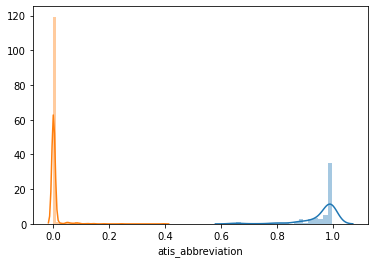

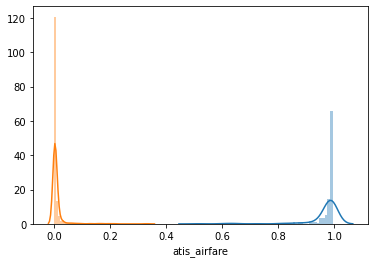

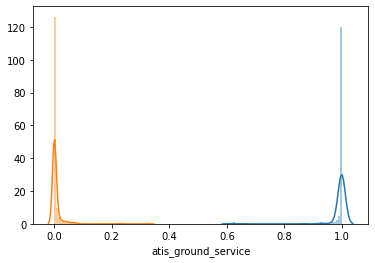

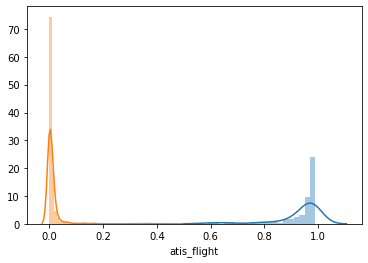

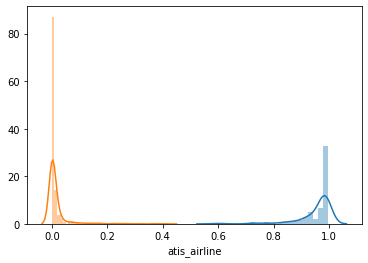

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
for i in list(set(correct.intent)):
  get_mem_dist(i)

In [14]:
from statistics import median

In [15]:
def low_mem_stats(intent):
  mu_low = round(mean(correct[correct.pred_intent != intent][intent]),3)
  variance_low = variance(correct[correct.pred_intent != intent][intent])
  sigma_low = round(math.sqrt(variance_low),3)
  return mu_low, sigma_low

def med_mem_stats(intent):
  mu_low = mean(correct[correct.pred_intent != intent][intent])
  mu_high = mean(correct[correct.pred_intent == intent][intent])
  med_rows = correct[(correct[intent] >= mu_low) & (correct[intent] <= mu_high)][intent]
  mu_med = round(mean(med_rows),3)
  s1 = 0.5*(mu_low+mu_med)
  s2 = 0.5*(mu_high+mu_med)
  core_med_rows = correct[(correct[intent] >= s1) & (correct[intent] <= s2)][intent]
  variance_med = variance(core_med_rows)
  sigma_med = round(math.sqrt(variance_med),3)
  return mu_med, sigma_med

def high_mem_stats(intent):
  mu_high = round(mean(correct[correct.pred_intent == intent][intent]),3)
  variance_high = variance(correct[correct.pred_intent == intent][intent])
  sigma_high = round(math.sqrt(variance_high),3)
  return mu_high, sigma_high

def get_perc_per_set(intent):
    n_low = len(correct[correct.pred_intent != intent][intent])
    p_low = n_low/len(correct)
    n_high = len(correct[correct.pred_intent == intent][intent])
    p_high = n_high/len(correct)
    
    mu_low = mean(correct[correct.pred_intent != intent][intent])
    mu_high = mean(correct[correct.pred_intent == intent][intent])
    med_rows = correct[(correct[intent] >= mu_low) & (correct[intent] <= mu_high)][intent]
    n_med = len(med_rows)
    p_med = n_med/len(correct)
    
    print('p_low:', p_low, ", p_med:", p_med, ", p_high:", p_high)

In [16]:
import matplotlib 
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'font.size':50,
    'font.weight':'bold',
    "axes.labelweight" : 'bold',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

In [17]:
import numpy as np
import matplotlib.pyplot as plt


def get_fuzzy_lims(intent):
  ##Low
  mu_low, sigma_low = low_mem_stats(intent)

  #High
  mu_high, sigma_high = high_mem_stats(intent)

  #Medium
  mu_med, sigma_med = med_mem_stats(intent)

  print("Low mem:", mu_low, sigma_low)
  print("Medium mem:", mu_med, ",", sigma_med)
  print("High mem:", mu_high, sigma_high)

  return mu_low, sigma_low, mu_med, sigma_med, mu_high, sigma_high


def sigmoid_low(x, slope, mu):
    s = 1 / (1 + np.exp(slope*(x-mu))) 
    return s

def sigmoid_high(x, slope, mu):
    s = 1 / (1 + np.exp(-1*slope*(x-mu))) 
    return s

def gaussian_med(x, mu, sigma):
  g = np.exp((-1*pow((x - mu),2))/(2*pow(sigma,2)))
  return g


def demo_mem_fns_soft(intent):
  str_intent = str(intent)
  mu_low, sigma_low, mu_med, sigma_med, mu_high, sigma_high = get_fuzzy_lims(intent)
  x = np.linspace(0,1,100)
#   plt.plot(x, sigmoid_low(x, slope= 10/(mu_med - mu_low), mu=0.5*(mu_low+mu_med)), color = 'r')
#   plt.plot(x, sigmoid_high(x, slope = 10/(mu_high - mu_med), mu=0.5*(mu_high+mu_med)), color = 'g')
  plt.figure(figsize=(15,7))
  p1, = plt.plot(x, sigmoid_low(x, slope= 10/mu_med, mu=0.5*(mu_low+mu_med)), '-', color = 'r', linewidth=4)
  p2, = plt.plot(x, sigmoid_high(x, slope = 10/(1-mu_med), mu=0.5*(mu_high+mu_med)), '--', color = 'g',linewidth=4)
  p3, = plt.plot(x, gaussian_med(x, mu = mu_med, sigma = sigma_med),  '-.', color = 'b', linewidth=4)
  plt.xlabel("softmax scores")
  plt.ylabel("membership degree")
  plt.title(str_intent)
  plt.legend([p1, p3, p2],["low", "medium", "high"])
  plt.show()
    
    
def demo_mem_fns_hard(intent):
  x = np.linspace(0,1,100)
#   plt.plot(x, sigmoid_low(x, slope= 10/(mu_med - mu_low), mu=0.5*(mu_low+mu_med)), color = 'r')
#   plt.plot(x, sigmoid_high(x, slope = 10/(mu_high - mu_med), mu=0.5*(mu_high+mu_med)), color = 'g')
  plt.figure(figsize=(15,7))
  p1, = plt.plot(x, sigmoid_low(x,  slope= 10/0.5, mu=0.25), '-', color = 'r', linewidth=4)
  p2, = plt.plot(x, sigmoid_high(x, slope = 10/0.5, mu=0.75),'--', color = 'g',linewidth=4)
  p3, = plt.plot(x, gaussian_med(x, mu = 0.5, sigma = 0.1), '-.', color = 'b', linewidth=4)
  plt.xlabel("softmax scores")
  plt.xlabel("softmax scores")
  plt.ylabel("membership degree")
  plt.legend([p1, p3, p2],["low", "medium", "high"])
#   plt.title(intent)
  plt.show()

In [18]:
import matplotlib 
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'font.size':20,
    'font.weight':'bold',
    "axes.labelweight" : 'bold',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

atis_abbreviation
p_low: 0.8304597701149425 , p_med: 0.11590038314176246 , p_high: 0.16954022988505746
Low mem: 0.004 0.023
Medium mem: 0.384 , 0.179
High mem: 0.956 0.068
atis_airfare
p_low: 0.8103448275862069 , p_med: 0.1685823754789272 , p_high: 0.1896551724137931
Low mem: 0.008 0.028
Medium mem: 0.21 , 0.105
High mem: 0.966 0.069
atis_ground_service
p_low: 0.7212643678160919 , p_med: 0.14080459770114942 , p_high: 0.27873563218390807
Low mem: 0.007 0.024
Medium mem: 0.216 , 0.058
High mem: 0.993 0.039
atis_flight
p_low: 0.8189655172413793 , p_med: 0.23371647509578544 , p_high: 0.1810344827586207
Low mem: 0.012 0.034
Medium mem: 0.188 , 0.123
High mem: 0.923 0.11
atis_airline
p_low: 0.8189655172413793 , p_med: 0.19348659003831417 , p_high: 0.1810344827586207
Low mem: 0.016 0.046
Medium mem: 0.297 , 0.124
High mem: 0.953 0.065


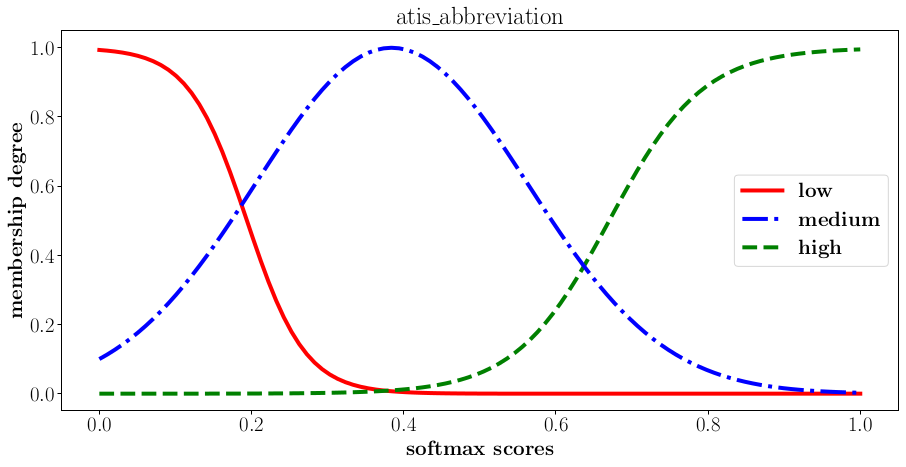

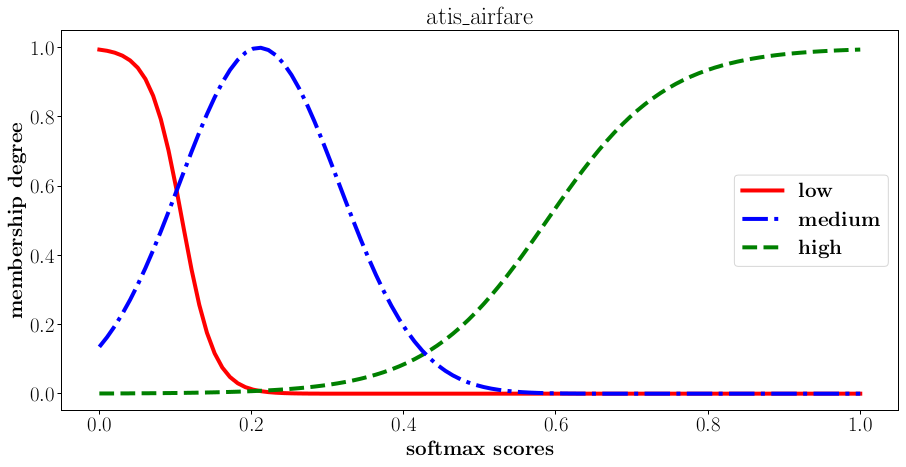

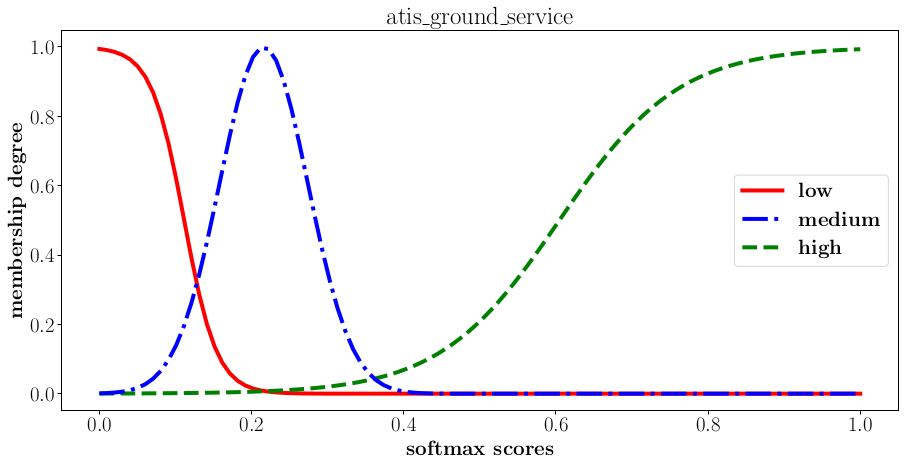

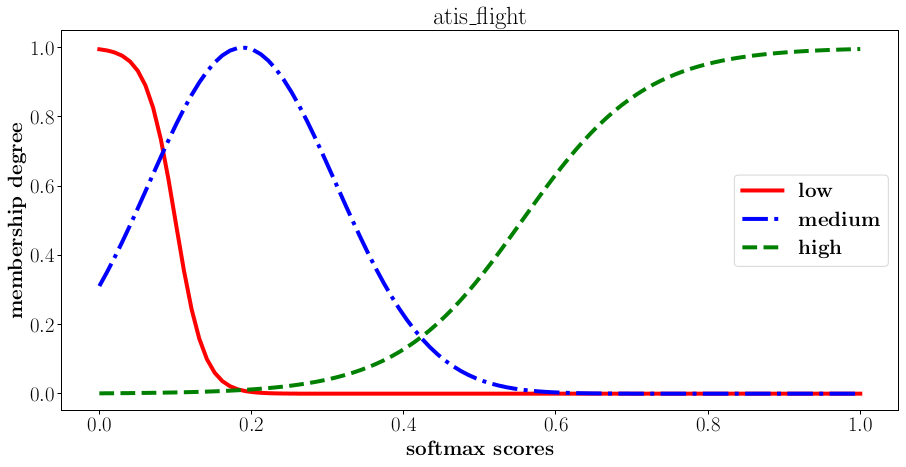

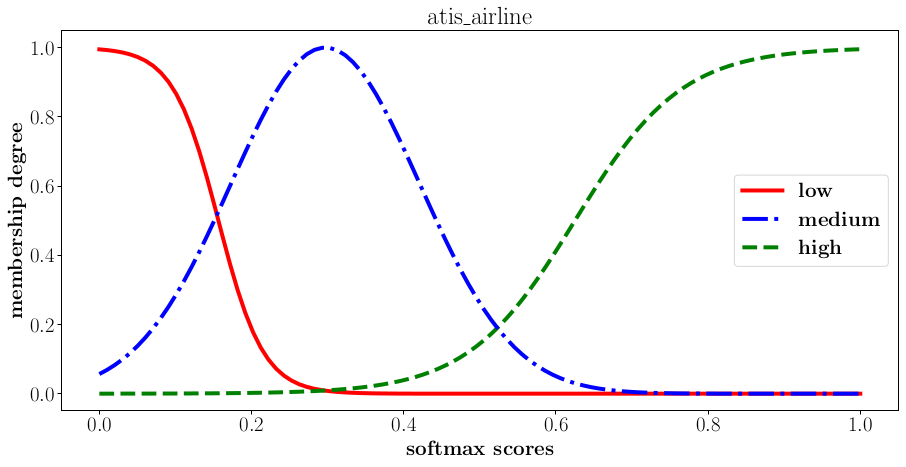

In [19]:
for i in list(set(full_data_new.intent_label)):
    print(i)
    get_perc_per_set(i)
    demo_mem_fns_soft(i)

In [31]:
import matplotlib.pyplot as plt
plt.rc(usetex = True)
params = {'tex.usetex': True}
plt.rcParams.update(params)

TypeError: rc() missing 1 required positional argument: 'group'

atis_flight
atis_ground_service
atis_airline
atis_abbreviation
atis_airfare


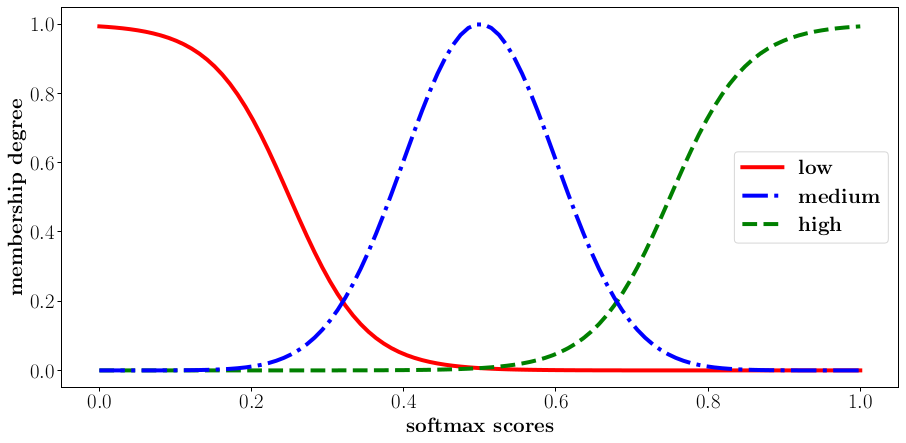

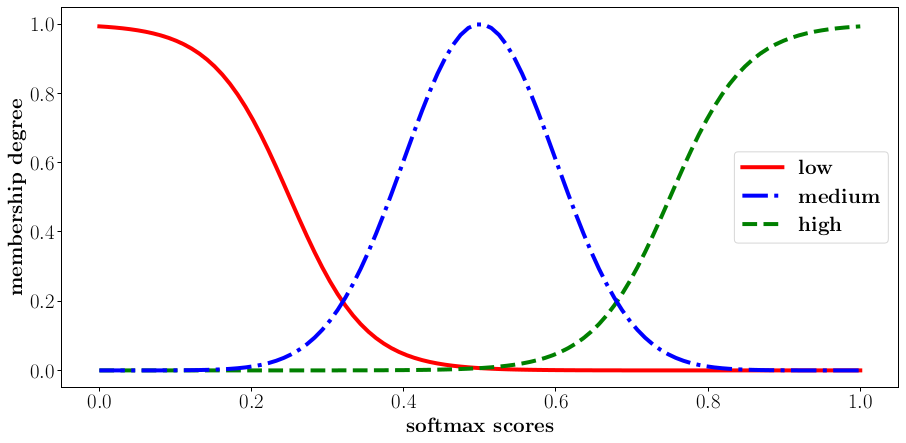

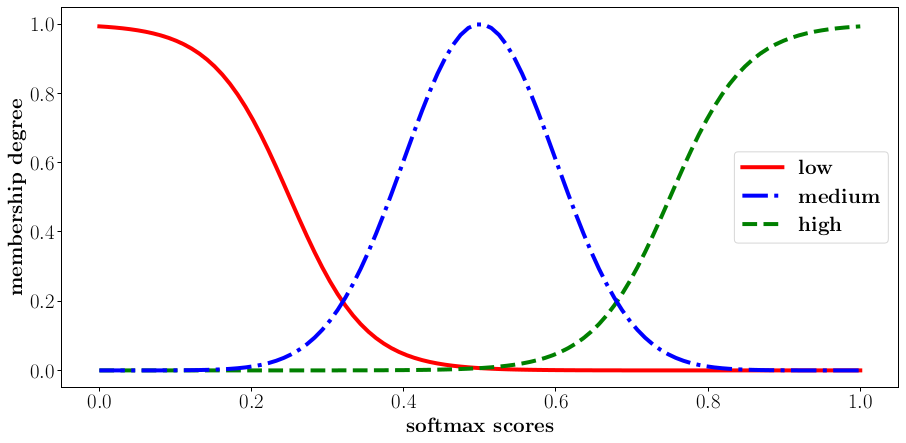

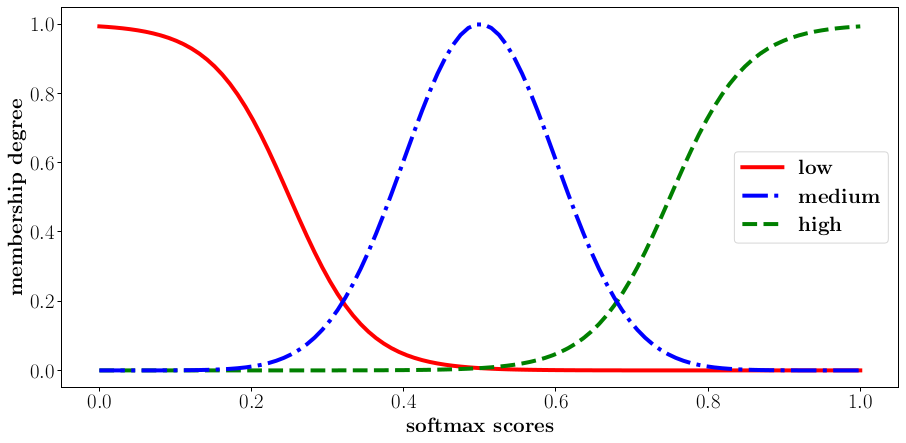

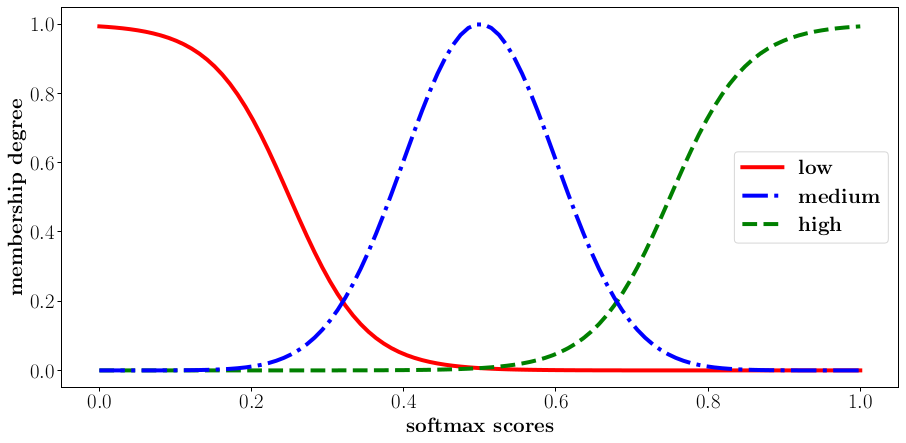

In [26]:
for i in list(set(full_data_new.intent_label)):
    print(i)
    demo_mem_fns_hard(i)

In [27]:
low_mem = {}
medium_mem = {}
high_mem = {}

for i in list(set(correct.intent)):
  low_mem[i] = low_mem_stats(i)
  medium_mem[i] = med_mem_stats(i)
  high_mem[i] = high_mem_stats(i)

In [41]:
def get_membership_demo_soft(value, intent):

  mu_low = low_mem[intent][0]
  mu_med, sigma_med = medium_mem[intent]
  mu_high = high_mem[intent][0]

  #Low
  mem_low = sigmoid_low(value, slope= 10/mu_med, mu=0.5*(mu_low+mu_med))
  #Medium
  mem_med = gaussian_med(value, mu = mu_med, sigma = sigma_med)
  #High
  mem_high = sigmoid_high(value, slope = 10/(1-mu_med), mu=0.5*(mu_high+mu_med))

  print("Low:", mem_low)
  print("Medium:", mem_med)
  print("High:", mem_high)

  # return mem_low, mem_med, mem_high

In [42]:
def get_membership_demo_hard(value, intent):

  #Low
  mem_low = sigmoid_low(value, slope= 10/0.5, mu=0.25)
  #Medium
  mem_med = gaussian_med(value, mu = 0.5, sigma = 0.1)
  #High
  mem_high = sigmoid_high(value, slope = 10/0.5, mu=0.75)

  print("Low:", mem_low)
  print("Medium:", mem_med)
  print("High:", mem_high)

  # return mem_low, mem_med, mem_high

In [43]:
def get_membership_soft(value, intent):

  mu_low = low_mem[intent][0]
  mu_med, sigma_med = medium_mem[intent]
  mu_high = high_mem[intent][0]

  #Low
  mem_low = sigmoid_low(value, slope= 10/mu_med, mu=0.5*(mu_low+mu_med))
  #Medium
  mem_med = gaussian_med(value, mu = mu_med, sigma = sigma_med)
  #High
  mem_high = sigmoid_high(value, slope = 10/(1-mu_med), mu=0.5*(mu_high+mu_med))

  return mem_low, mem_med, mem_high

In [44]:
def get_membership_hard(value, intent):

  #Low
  mem_low = sigmoid_low(value, slope= 10/0.5, mu=0.25)
  #Medium
  mem_med = gaussian_med(value, mu = 0.5, sigma = 0.1)
  #High
  mem_high = sigmoid_high(value, slope = 10/0.5, mu=0.75)

  return mem_low, mem_med, mem_high

In [52]:
get_membership_demo_soft(0., 'atis_flight')

Low: 6.752440720215651e-17
Medium: 4.208744292873671e-06
High: 0.9530723490558455


In [54]:
get_membership_demo_hard(0.7, 'atis_flight')

Low: 0.00012339457598623172
Medium: 0.13533528323661287
High: 0.26894142136999494


In [56]:
correct_hard = correct.copy()

In [57]:
correct[['atis_abb_low']] = [get_membership_soft(x, 'atis_abbreviation')[0] for x in correct['atis_abbreviation']]
correct[['atis_abb_med']] = [get_membership_soft(x, 'atis_abbreviation')[1] for x in correct['atis_abbreviation']]
correct[['atis_abb_high']] = [get_membership_soft(x, 'atis_abbreviation')[2] for x in correct['atis_abbreviation']]

correct[['atis_airfare_low']] = [get_membership_soft(x, 'atis_airfare')[0] for x in correct['atis_airfare']]
correct[['atis_airfare_med']] = [get_membership_soft(x, 'atis_airfare')[1] for x in correct['atis_airfare']]
correct[['atis_airfare_high']] = [get_membership_soft(x, 'atis_airfare')[2] for x in correct['atis_airfare']]

correct[['atis_airline_low']] = [get_membership_soft(x, 'atis_airline')[0] for x in correct['atis_airline']]
correct[['atis_airline_med']] = [get_membership_soft(x, 'atis_airline')[1] for x in correct['atis_airline']]
correct[['atis_airline_high']] = [get_membership_soft(x, 'atis_airline')[2] for x in correct['atis_airline']]

correct[['atis_flight_low']] = [get_membership_soft(x, 'atis_flight')[0] for x in correct['atis_flight']]
correct[['atis_flight_med']] = [get_membership_soft(x, 'atis_flight')[1] for x in correct['atis_flight']]
correct[['atis_flight_high']] = [get_membership_soft(x, 'atis_flight')[2] for x in correct['atis_flight']]

correct[['atis_ground_service_low']] = [get_membership_soft(x, 'atis_ground_service')[0] for x in correct['atis_ground_service']]
correct[['atis_ground_service_med']] = [get_membership_soft(x, 'atis_ground_service')[1] for x in correct['atis_ground_service']]
correct[['atis_ground_service_high']] = [get_membership_soft(x, 'atis_ground_service')[2] for x in correct['atis_ground_service']]

In [59]:
correct.to_csv('./results/softmax_data/SI_softmax_ATIS.csv')

In [61]:
correct_hard[['atis_abb_low']] = [get_membership_hard(x, 'atis_abbreviation')[0] for x in correct_hard['atis_abbreviation']]
correct_hard[['atis_abb_med']] = [get_membership_hard(x, 'atis_abbreviation')[1] for x in correct_hard['atis_abbreviation']]
correct_hard[['atis_abb_high']] = [get_membership_hard(x, 'atis_abbreviation')[2] for x in correct_hard['atis_abbreviation']]

correct_hard[['atis_airfare_low']] = [get_membership_hard(x, 'atis_airfare')[0] for x in correct_hard['atis_airfare']]
correct_hard[['atis_airfare_med']] = [get_membership_hard(x, 'atis_airfare')[1] for x in correct_hard['atis_airfare']]
correct_hard[['atis_airfare_high']] = [get_membership_hard(x, 'atis_airfare')[2] for x in correct_hard['atis_airfare']]

correct_hard[['atis_airline_low']] = [get_membership_hard(x, 'atis_airline')[0] for x in correct_hard['atis_airline']]
correct_hard[['atis_airline_med']] = [get_membership_hard(x, 'atis_airline')[1] for x in correct_hard['atis_airline']]
correct_hard[['atis_airline_high']] = [get_membership_hard(x, 'atis_airline')[2] for x in correct_hard['atis_airline']]

correct_hard[['atis_flight_low']] = [get_membership_hard(x, 'atis_flight')[0] for x in correct_hard['atis_flight']]
correct_hard[['atis_flight_med']] = [get_membership_hard(x, 'atis_flight')[1] for x in correct_hard['atis_flight']]
correct_hard[['atis_flight_high']] = [get_membership_hard(x, 'atis_flight')[2] for x in correct_hard['atis_flight']]

correct_hard[['atis_ground_service_low']] = [get_membership_hard(x, 'atis_ground_service')[0] for x in correct_hard['atis_ground_service']]
correct_hard[['atis_ground_service_med']] = [get_membership_hard(x, 'atis_ground_service')[1] for x in correct_hard['atis_ground_service']]
correct_hard[['atis_ground_service_high']] = [get_membership_hard(x, 'atis_ground_service')[2] for x in correct_hard['atis_ground_service']]

In [62]:
correct_hard.to_csv('./results/softmax_data/SI_hardmax_ATIS.csv')